In [1]:
import dgl
from sklearn.neighbors import kneighbors_graph
import numpy as np
import pandas as pd
import torch
import pickle
from tqdm import trange
import histocartography
import matplotlib.pyplot as plt
import copy
from histocartography.ml import CellGraphModel
import io
from histocartography.interpretability import (
    GraphGradCAMExplainer,
    GraphGradCAMPPExplainer,
)
import importlib
importlib.reload(histocartography)
from histocartography.ml import CellGraphModel
from histocartography.interpretability import (
    GraphGradCAMExplainer,
    GraphGradCAMPPExplainer,
)
import copy
from collections import OrderedDict
from itertools import islice

Using backend: pytorch


In [2]:
DATA_PATH = './data/'
with open(DATA_PATH+'graphs_labels.pkl','rb') as f:
    data = pickle.load(f)
data = data[0]
node_dim = data[0][0].ndata['feat'].shape[1]
with open(DATA_PATH+'cluster_ids.pkl','rb') as f:
    labs_ids = pickle.load(f)
labs = labs_ids["labs"]
ids = labs_ids["ids"]

In [3]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

...
#contents = pickle.load(f) becomes...
with open(DATA_PATH+'hypopt.pkl','rb') as f:
    vals_gins = CPU_Unpickler(f).load()
with open(DATA_PATH+'hypopt2.pkl','rb') as f:
    vals_gins2 = CPU_Unpickler(f).load()

In [4]:
with open(DATA_PATH+'cgm_reps.pkl','rb') as f:
    cgm_reps = pickle.load(f)

In [5]:
# if above models don't work, can retrain them
cgms = []
from torch.utils.data import DataLoader
import random
from tqdm import trange
# 3. Batchify and train/val split the data
random.shuffle(data)
train_data = data[:int(len(data)* 0.7)]
val_data = data[int(len(data)*0.7):]
batch_size = 8

def collate(batch):
    g = dgl.batch([example[0] for example in batch])
    l = torch.LongTensor([example[1] for example in batch])
    return g, l

train_dataloader = DataLoader(data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(data, batch_size, collate_fn=collate)

In [6]:
for v in [vals_gins2]:
    val = [d['total_accuracy'] for d in v]
    classification_params = v[np.argmax(val)]['classification_params']
    gnn_params = v[np.argmax(val)]['gnn_params']
    cgm = CellGraphModel(gnn_params,classification_params,node_dim,num_classes = 2)

    # build optimizer
    optimizer = torch.optim.Adam(
        cgm.parameters(),
        lr=10e-3,
        weight_decay=5e-4
    )

    # define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # training 
    val_loss = 10e5
    val_accuracy = 0.

    with trange(1) as t:
        for epoch in t:
            t.set_description('Validation with loss={} | accuracy={}'.format(val_loss, val_accuracy))
            # A.) train for 1 epoch 
            cgm.train()
            for gs, ls in train_dataloader:

                # 1. forward pass
                logits = cgm(gs)

                # 2. backward pass
                loss = loss_fn(logits, ls)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            cgm.eval()
            all_val_logits = []
            all_val_labels = []
            for gs, ls in val_dataloader:
                with torch.no_grad():
                    logits = cgm(gs)
                all_val_logits.append(logits)
                all_val_labels.append(ls)

            all_val_logits = torch.cat(all_val_logits).cpu()
            all_val_labels = torch.cat(all_val_labels).cpu()

            with torch.no_grad():
                val_loss = round(loss_fn(all_val_logits, all_val_labels).item(), 2)
                _, predictions = torch.max(all_val_logits, dim=1)
                correct = torch.sum(predictions.to(int) == all_val_labels.to(int))
                val_accuracy = round(correct.item() * 1.0 / len(all_val_labels), 2)
    cgms.append(copy.deepcopy(cgm))

Validation with loss=1000000.0 | accuracy=0.0: 100%|█| 1/1 [00:03<00:00,  3.46s/


In [7]:
len(cgms)

1

In [12]:
exp = GraphGradCAMPPExplainer(model=cgms[0],gnn_layer_ids=['0','1'],gnn_layer_name='cell_graph_gnn')

In [7]:
scores_per_graph = []
for graph,target in data:
    l = graph.ndata['label'].numpy()
    pos = graph.ndata['centroid'].numpy()
    cell_id = graph.ndata['cell_ids']
    graph_id = graph.ndata['graph_id']
    l = [labs[int(i)] for i in l]
    d = pd.DataFrame({'cell_type':l,'X':pos[:,0],'Y':pos[:,1],
                         'cell_id':cell_id,'graph_id':graph_id})
    num_models = len(cgm_reps)
    for i,cgm in enumerate(cgm_reps):
        grad_campp_explainer = GraphGradCAMPPExplainer(model=cgm,gnn_layer_ids=['0','1'],gnn_layer_name='cell_graph_gnn')
        score = grad_campp_explainer.process(graph)[0]
        d[f'campp_{i}'] = score
        with torch.no_grad():
            c = copy.deepcopy(graph)
            logits = cgm(c)
            pred = torch.argmax(logits)
        d.attrs[f'pred_{i}'] = 3.0 if pred == 0 else 4.0
    d['campp_median'] = d.loc[:,'campp_0':f'campp_{num_models-1}'].median(axis=1)
    d['campp_mad'] = d.loc[:,'campp_0':f'campp_{num_models-1}'].mad(axis=1)
    d.attrs['stage'] = 3.0 if target == 0 else 4.0
    scores_per_graph.append(d)

In [8]:
with open(DATA_PATH + 'scores_per_graph.pkl','wb') as f:
    pickle.dump(scores_per_graph,f)

In [52]:
comp_map = []
for cgm in [cgms[0]]:    
    grad_campp_explainer = GraphGradCAMPPExplainer(model=cgm)
    # grad_cam_explainer = GraphGradCAMExplainer(model=cgm)
    importance_scores_grad_campp = []
    # importance_scores_grad_cam = []
    for e in data:
        graph = e[0]
        importance_scores_grad_campp.append(grad_campp_explainer.process(graph)[0])
        # importance_scores_grad_cam.append(grad_cam_explainer.process(graph)[0])
        
    cgm.eval()
    scores_labels = []
    for score_campp,score_cam,e in zip(importance_scores_grad_campp,
                                            importance_scores_grad_cam,
                                            data):
        graph = e[0]
        # print(graph)
        target = e[1]
        # print(target)
        with torch.no_grad():
            c = copy.deepcopy(graph)
            logits = cgm(c)
            pred = torch.argmax(logits)
        l = graph.ndata['label'].numpy()
        pos = graph.ndata['centroid'].numpy()
        cell_id = graph.ndata['cell_ids']
        graph_id = graph.ndata['graph_id']
        l = [labs[int(i)] for i in l]
        d = pd.DataFrame({'cell_type':l,'score_campp':score_campp,
                          'score_cam':score_cam,'X':pos[:,0],'Y':pos[:,1],
                         'cell_id':cell_id,'graph_id':graph_id})
        d.attrs['stage'] = 3.0 if target == 0 else 4.0
        d.attrs['pred'] = 3.0 if pred == 0 else 4.0
        scores_labels.append(d)
    comp_map.append({
        'model': cgm,
        'scores_labels': scores_labels
    })

In [53]:
with open(DATA_PATH+'comparison_map.pkl','wb') as f:
    pickle.dump(comp_map,f)

In [292]:
list_of_df = comp_map[0]['scores_labels']

[              cell_type   score_campp  score_cam       X       Y  cell_id  \
 0          granulocytes  7.060715e-02   0.081295    98.0   482.0      182   
 1          granulocytes  2.210505e-02   0.029742   121.0   664.0      183   
 2          granulocytes  7.067740e-03   0.006584   131.0   651.0      184   
 3          granulocytes  4.391450e-02   0.049668   213.0   162.0      185   
 4          granulocytes  9.513804e-02   0.118045   219.0   148.0      186   
 ...                 ...           ...        ...     ...     ...      ...   
 2665             nerves  9.314149e-03   0.009354  1240.0  1302.0   254009   
 2666             nerves  5.910956e-04   0.000593  1498.0   874.0   254010   
 2667             nerves  2.865409e-06   0.000000  1517.0  1036.0   254011   
 2668  CD68+ macrophages  1.057396e-04   0.000000   749.0   425.0   254844   
 2669         lymphatics  5.283553e-07   0.000000   335.0   106.0   256951   
 
       graph_id  
 0            3  
 1            3  
 2      

In [54]:
scores_labels = comp_map[0]['scores_labels']
scl = scores_labels[0]

In [188]:
comp_map

1

In [55]:
scl.sort_values('score_campp',ascending=False).cell_type[:100].value_counts()

tumor cells             76
vasculature             15
granulocytes             5
CD8+ T cells             2
dirt                     1
CD4+ T cells CD45RO+     1
Name: cell_type, dtype: int64

In [56]:
scl.sort_values('score_cam',ascending=False).cell_type[:100].value_counts()

tumor cells             75
vasculature             14
granulocytes             7
CD8+ T cells             2
dirt                     1
CD4+ T cells CD45RO+     1
Name: cell_type, dtype: int64

In [293]:
scl.cell_type.value_counts()

tumor cells                   2189
granulocytes                   181
vasculature                     64
smooth muscle                   55
dirt                            47
stroma                          37
CD8+ T cells                    18
CD68+CD163+ macrophages         16
tumor cells / immune cells      12
B cells                         10
CD4+ T cells CD45RO+             9
undefined                        9
Tregs                            6
nerves                           5
adipocytes                       4
immune cells                     3
immune cells / vasculature       1
CD11c+ DCs                       1
plasma cells                     1
lymphatics                       1
CD68+ macrophages                1
Name: cell_type, dtype: int64

In [294]:
scl.attrs

{'stage': 3.0, 'pred': 3.0}

In [295]:
mismatch = [scl for scl in scores_labels if scl.attrs['stage'] != scl.attrs['pred']]

In [296]:
len(mismatch)

7

In [60]:
len(scores_labels)

140

In [61]:
scl = mismatch[0]

In [63]:
scl.sort_values('score_campp',ascending=False).cell_type[:100].value_counts()

CD68+CD163+ macrophages    53
Tregs                      19
CD8+ T cells                7
adipocytes                  7
dirt                        3
CD11b+CD68+ macrophages     3
B cells                     2
CD11c+ DCs                  2
smooth muscle               2
granulocytes                1
plasma cells                1
Name: cell_type, dtype: int64

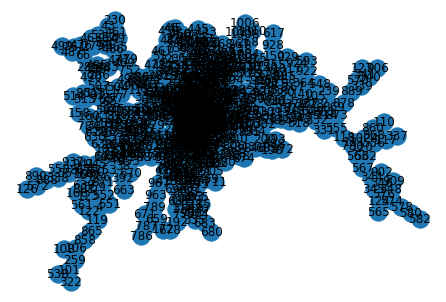

In [26]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = data[0][0].to_networkx(node_attrs[']).to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

    Similarity algorithms employ set comparisons to score how alike individual nodes are based on their neighbors or properties. The properties and attributes of nodes are used to score the likeness between nodes. This approach is used in applications such as personalized recommendations and developing categorical hierarchies.
    
Can compare important nodes in same graph? In different graphs? How are important nodes the same/different?

    Centrality algorithms reveal which nodes are important based on graph topology. They identify influential nodes based on their position in the network and include the famous PageRank algorithm. These algorithms are used to infer group dynamics such as credibility, rippling vulnerability and bridges between groups.
    
Compare important 'central' nodes with those that have high importance scores - are these the same? How do they differ? What measures of centrality correlate the most with the important nodes? Is that the same for both stages of cancer? How much within-subject vs between-subject variation is there?

    Community Detection algorithms cluster your graph based on relationships to find communities where members have more significant interactions. This category includes popular algorithms – such as Connected Components and Louvain Modularity. Detecting communities helps predict similar behavior, find duplicate entities or simply prepare data for other analyses.

Do certain communities tend to contain more important nodes? How does this change between cancer stages?

**Robustness of training - I just saw a model that completely flipped the important cell types (from almost exclusively plasma cells to mostly tumor cells). May need to bootstrap this or something. What is up with lack of robustness?**

In [207]:
from networkx import algorithms as nxa
import networkx

In [210]:
def compare_importance(data,scores_labels,g_id,metric=nxa.degree_centrality,
                      set_size_gnn=100,set_size_metric=100,pruning_scores=None):
    scl = scores_labels[g_id]
    if pruning_scores is not None:
        scl['pruning_score'] = pruning_scores
    g = data[g_id][0].to_networkx(node_attrs=['feat','label','centroid','cell_ids','graph_id']).to_undirected()
    g = networkx.Graph(g.copy())
    if pruning_scores is not None:
        scl['pruning_score'] = pruning_scores
        top_gnn_ids = scl.sort_values('pruning_score',ascending=False).cell_id[:set_size_gnn].to_numpy()
    else:
        top_gnn_ids = scl.sort_values('score_campp',ascending=False).cell_id[:set_size_gnn].to_numpy()
    met = metric(g)
    met = OrderedDict(sorted(met.items(), 
                                  key=lambda kv: kv[1], reverse=True))
    top_met_nodes = list(met)[:set_size_metric]
    top_met_ids = np.array([g.nodes()[x]['cell_ids'].item() for x in top_met_nodes])
    top_comb_ids = list(set(top_met_ids) & set(top_gnn_ids))
    top_comb_nodes = [n for i in top_comb_ids for n,v in g.nodes(data=True)if v['cell_ids'] == i]
    top_comb_campp_scores = [scl[scl['cell_id'] == i].score_campp.values[0] for i in top_comb_ids]
    max_campp_score = scl.score_campp.max()
    top_comb_campp_ranks = [list(top_gnn_ids).index(i) for i in top_comb_ids]
    top_comb_met = [met[i] for i in top_comb_nodes]
    top_comb_met_ranks = [list(met.keys()).index(i) for i in top_comb_nodes]
    max_met = max(met.values())
    d = pd.DataFrame({'cell_id':top_comb_ids,'node':top_comb_nodes,
                          'top_comb_campp_score':top_comb_campp_scores,'max_campp_score':max_campp_score,'top_comb_campp_rank':top_comb_campp_ranks,
                         'top_comb_met':top_comb_met,'max_met':max_met,'top_comb_met_rank':top_comb_met_ranks})
    return d

    degree_centrality,betweenness_centrality, load_centrality, katz_centrality, harmonic_centrality, closeness_centrality


In [224]:
centrality_df = compare_importance(data,scores_labels,0,metric=nxa.degree_centrality)

In [225]:
centrality_df

,cell_id,node,top_comb_campp_score,max_campp_score,top_comb_campp_rank,top_comb_met,max_met,top_comb_met_rank
0,22464,185,0.125586,0.97881,94,0.003747,0.003747,0
1,50905,452,0.179814,0.97881,68,0.002997,0.003747,39
2,22491,212,0.202733,0.97881,63,0.002997,0.003747,27
3,51278,825,0.221986,0.97881,55,0.002997,0.003747,52


**Also compare to classification accuracy just using features (no graph topology)**

**Different methods for graph construction?**

**Robustness of importance scores per model (CV)**

**Robustness of importance scores across model types**

**Robustness of importance scores across importance score types**

So it doesn't seem like there is a lot of crossover between "central" nodes and important nodes from the GNN (though the most degree-central node is in the top 100 important nodes for the GNN)

In [279]:
g = data[0][0].to_networkx(node_attrs=['label','centroid','cell_ids','graph_id']).to_undirected()

In [280]:
len(g.nodes[0]['centroid'].shape)

1

In [281]:
num_nodes = len(g.nodes())
for i in range(num_nodes):
    v = g.nodes[i]['centroid']
    g.nodes[i]['X'] = v[0].item()
    g.nodes[i]['Y'] = v[1].item()
    g.nodes[i]['label'] = g.nodes[i]['label'].item()
    g.nodes[i]['cell_ids'] = g.nodes[i]['cell_ids'].item()
    g.nodes[i]['graph_id'] = g.nodes[i]['graph_id'].item()

for i in range(num_nodes):
    g.nodes[i].pop('centroid',None)

In [282]:
g.nodes[0]

{'label': 17.0, 'cell_ids': 182, 'graph_id': 3, 'X': 98.0, 'Y': 482.0}

In [283]:
networkx.write_graphml(g, DATA_PATH + 'g0.gml') 

In [284]:
from histocartography.interpretability import GraphPruningExplainer
pruning_explainer = GraphPruningExplainer(model=cgms[0])

In [287]:
g_pruning_scores = pruning_explainer.process(graph=data[0][0],label=data[0][1])

Process:: 100%|█████████████████████████████| 500/500 [01:05<00:00,  7.66step/s]


In [290]:
g_pruning_scores[0]

13.950309894979